# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import torch
from torch import nn
from tensorflow.keras.datasets import mnist, fashion_mnist
from tqdm.auto import tqdm

# Problem description
The task is to able to identify anomalies in a time series when working with stream data.

# Methodology

## Algorithms
Robust Random Cut Forest, as described in [Robust Random Cut Forest Based Anomaly Detection On Streams](http://proceedings.mlr.press/v48/guha16.pdf)  

## Validation
Objectively evaluating the accuracy of the model turned out to be quite difficult, since anomaly detection is an unsupervised learning task.  
The major problem comes from trouble in defining an anomaly. Anomaly detection task seems to be a simple binary classification task. But how do we determine the boundary between what we consider normal and anomalous behaviour?

In the paper, anomalies are defined as points that, if included, significantly increase the complexity of a model. This definition makes sense in terms of defining desired model output, but since it's intrinsically tied to the model, is quite useless when it comes to manually labeling anomalies for validation.

I've considered following approaches to labeling:

1.   When it comes to artificially generated data, we inject the anomalies ourselves, so we can easily tag the places where they occur.
2.   We could use domain knownledge to mark certain events that are likely to cause anomalous behaviour. That's the case in paper I linked to: authors used a NYC taxicabs, and manually tagged the dates of events such as holidays or marathon.
3.   Another option is to manually go through the time series and arbitrarily assign a label to each point in time. This approach, however, seems neither elegant nor efficient.

Another question is how to handle long-lasting anomalies. I've settled on tagging only the start and the end of that period as an anomaly, since our practical goal is exactly that - to detect a change in the nature of data.  


I calculate loss as follows:  
For each point marked as anomaly, I mark every shingle containg it as anomalous. Those shingles form continuous intervals. If no window in the interval is classified as an anomaly, I treat the whole interval as false negative. If, however, a positively classified shingle doesn't belong to any intervals, then it is treated as false positive.

The loss function also has two hyperparameters:
alpha and beta, which are respectively weights associated with positive and negative samples.

As such, the final formula is:  
$$\alpha \cdot F_p + \beta \cdot F_n$$
where F_p is the number of false positives and F_n - false negatives

To set a codisp score threshold for classification as anomaly, I simply check multiple points in the interval (min_score, max_score) and select the one with lowest loss.  
Since the search space is really small, even this naive method works great.

# Implementation
I made the following major changed with regards to implementation proposed in the paper:

1.   Leaves can contain a set of points instead of a singular point, if all of them are very similar (required similarity can be regulated using leaf_threshold parameter).
2.   I added the possibility of per-tree normalisation of the scores returned by the model. Final results are calculated without normalisation, as I've found it doesn't offer significant improvement, especially when using large number of trees.

When it comes to efficiency, the major improvement that could be added is parallel computation. Since we're creating a forest of independent trees, this should be pretty straightforward.

## Robust Random Cut Forests

In [ ]:
class RobustRandomCutTree():

    def __init__(self, df=None, leaf_threshold=np.exp(-20), seed=None):
        self.rs = np.random.RandomState(seed)

        self.leaf_threshold = leaf_threshold
        self.max_codisp_so_far = None

        if df is not None:
            self.root = self.build_tree(df)
        else:
            self.root = None
        

    def build_tree(self, df, displacement=0):
        amplitudes = df.max() - df.min()

        if len(df) == 1 or np.all(amplitudes < self.leaf_threshold):
            return self.Leaf(df, displacement, self.leaf_threshold)
        
        return self.build_node(df, displacement)


    def build_node(self, df, displacement):
        amplitudes = df.max() - df.min()

        cut_dim = self.rs.choice(len(df.columns), p=(amplitudes/amplitudes.sum()))
        cut_point = self.rs.uniform(low=df.iloc[:, cut_dim].min(),
                                    high=df.iloc[:, cut_dim].max())

        left_df = df[df.iloc[:, cut_dim] < cut_point]
        right_df = df[df.iloc[:, cut_dim] >= cut_point]

        return self.Node(self.build_tree(left_df, len(right_df)),
                         self.build_tree(right_df, len(left_df)),
                         df.min(), df.max(), cut_dim, cut_point, displacement)


    def get_codisp(self, point, normalise=False):
        def traverse(node, max_codisp = 0):
            codisp = node.displacement / node.size
            max_codisp = max(max_codisp, codisp)

            if isinstance(node, self.Leaf):
                if node.belongs(point):
                    return max_codisp
                else:
                    raise ValueError("Point not found in the tree")
            else:
                if point[node.cut_dim] < node.cut_point:
                    return traverse(node.left, max_codisp)
                else:
                    return traverse(node.right, max_codisp)
        
        codisp = traverse(self.root)

        if self.max_codisp_so_far is None or self.max_codisp_so_far < codisp:
            self.max_codisp_so_far = codisp

        if normalise:
            codisp /= self.max_codisp_so_far
        
        return codisp


    def insert_point(self, point):

        def traverse(node):
            if isinstance(node, self.Leaf):
                new_df = node.points.append(pd.DataFrame([point]))
                return self.build_tree(new_df, node.displacement)
            else:
                max_vals = np.maximum(point, node.max_vals)
                min_vals = np.minimum(point, node.min_vals)

                amplitudes = max_vals - min_vals
                
                cut_dim = self.rs.choice(len(point), p=(amplitudes/amplitudes.sum()))
                cut_point = self.rs.uniform(low=min_vals[cut_dim],
                                            high=max_vals[cut_dim])
                
                if cut_point < node.min_vals[cut_dim]:

                    left = self.Leaf(pd.DataFrame([point]), node.size, self.leaf_threshold)
                    right = self.Node(node.left, node.right, node.min_vals, node.max_vals,
                                      node.cut_dim, node.cut_point, 1)

                    return self.Node(left, right, min_vals, max_vals, cut_dim, cut_point, node.displacement)

                elif cut_point >= node.max_vals[cut_dim]:

                    left = self.Node(node.left, node.right, node.min_vals, node.max_vals,
                                     node.cut_dim, node.cut_point, 1)
                    right = self.Leaf(pd.DataFrame([point]), node.size, self.leaf_threshold)

                    return self.Node(left, right, min_vals, max_vals, cut_dim, cut_point, node.displacement)
                
                elif (point[node.cut_dim] < node.cut_point):
                    
                    node.min_vals = min_vals
                    node.max_vals = max_vals
                    node.right.displacement += 1
                    node.left = traverse(node.left)
                    return node

                else:

                    node.min_vals = min_vals
                    node.max_vals = max_vals
                    node.left.displacement += 1
                    node.right = traverse(node.right)
                    return node


        if self.root is None:
            self.root = self.Leaf(pd.DataFrame([point]), 0, self.leaf_threshold)

        traverse(self.root)


    class Node():
        def __init__(self, left, right, min_vals, max_vals, cut_dim, cut_point, displacement):
            self.left = left
            self.right = right

            self.min_vals = min_vals
            self.max_vals = max_vals

            self.cut_dim = cut_dim
            self.cut_point = cut_point

            self.size = left.size + right.size
            self.displacement = displacement


    class Leaf():
        def __init__(self, points, displacement, leaf_threshold):
            self.points = points

            self.size = len(points)
            self.displacement = displacement

            self.leaf_threshold = leaf_threshold


        def belongs(self, point):
            amplitudes = (np.maximum(point, self.points.max()) -
                          np.minimum(point, self.points.min()))
            return np.all(amplitudes < self.leaf_threshold)

In [ ]:
class RobustRandomCutForest():

    def __init__(self, df = None, num_trees = 10, seed=None, **kwargs):
        self.points = list(df.values)
        self.rs = np.random.RandomState(seed)

        seeds = self.rs.choice(num_trees*1000, size=num_trees, replace=False)

        self.ensemble = [RobustRandomCutTree(df, seed=tree_seed, **kwargs)
                         for tree_seed in seeds]


    def get_codisps(self, normalise=False, points=None):
        def tree_codisps(tree):
            codisps = np.array([tree.get_codisp(shingle) for shingle in points])
            if normalise:
                codisps /= tree.max_codisp_so_far
            return codisps

        if points is None:
            points = self.points

        codisps = np.array([tree_codisps(tree) for tree in self.ensemble])
        return codisps


    def get_mean_codisps(self, **kwargs):
        codisps = self.get_codisps(**kwargs)
        return codisps.mean(axis=0)
    
    def insert_point(self, point):
        for tree in self.ensemble:
            tree.insert_point(point)
        self.points.append(point)

## Utilities

In [ ]:
def shingle(time_series, size):
    ts_length = len(time_series)
    if size > ts_length:
        raise ValueError('shingle cannot be longer than the time series')
    shingles = (np.arange(ts_length - size + 1).reshape(-1, 1) +
                np.arange(size).reshape(1, -1))
    return pd.DataFrame(time_series[shingles])

In [ ]:
def plot_stats(ts):
    fig, axes = plt.subplots(2, 1, figsize=(12,8))
    plt.subplots_adjust(hspace=0.5)

    axes[0].set_title('Time series')
    ts['rows'].plot(label='data', ax=axes[0])
    axes[0].set_xlabel('Time')
    axes[0].legend()


    axes[1].set_title('First order differentiating')
    ts['diff'].plot(label='data', ax=axes[1])
    axes[1].set_xlabel('Time')
    axes[1].legend()

In [ ]:
def anomaly_loss(predictions, labels, alpha=3, beta=1):
    loss = 0 

    in_anomaly = False
    anomaly_predicted = False

    for idx in range(len(labels)):
        if labels[idx] == 0:
            if in_anomaly:
                in_anomaly = False
                if not anomaly_predicted:
                    loss += alpha
                anomaly_predicted = False
            
            if predictions[idx] == 1:
                loss += beta
        
        elif labels[idx] == 1:
            in_anomaly = True
            if predictions[idx] == 1:
                anomaly_predicted = True

    return loss

In [ ]:
def misclassifications(predictions, labels):
    false_positives = 0
    false_negatives = 0

    in_anomaly = False
    anomaly_predicted = False

    for idx in range(len(labels)):
        if labels[idx] == 0:
            if in_anomaly:
                in_anomaly = False
                if not anomaly_predicted:
                    false_negatives += 1
                anomaly_predicted = False
            
            if predictions[idx] == 1:
                false_positives += 1
        
        elif labels[idx] == 1:
            in_anomaly = True
            if predictions[idx] == 1:
                anomaly_predicted = True

    return false_positives, false_negatives


# Data

## Sine

### Time series generation

In [ ]:
def generate_anomalous_sin(ts_len, anomalies, start=0, end=20*np.pi, shingle_len=7,
                           noise=None, seed=None):
    rs = np.random.RandomState(seed)

    sin_ts = np.sin(np.linspace(start, end, ts_len))
    is_anomaly = np.zeros(ts_len)

    for anomaly in anomalies:
        sin_ts[anomaly[0]:anomaly[1]] = anomaly[2]
        is_anomaly[anomaly[0]] = 1
        is_anomaly[anomaly[1]] = 1

    if noise is not None:
        sin_ts += rs.normal(0, noise, ts_len)

    sin_shingles = shingle(sin_ts, shingle_len)
    anomalous_shingles = shingle(is_anomaly, shingle_len)
    anomalous_shingles = anomalous_shingles.max(axis=1)

    return sin_ts, is_anomaly, sin_shingles, anomalous_shingles

### Tests

#### Simple time series

In [ ]:
ts_len = 500
shingle_len = 7

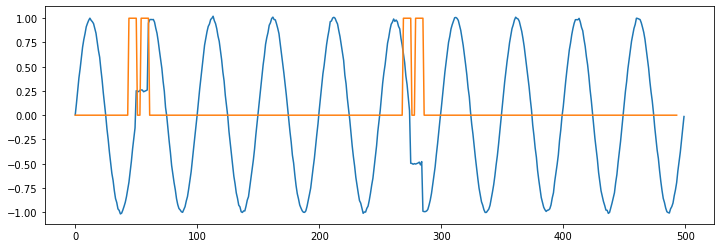

In [ ]:
# Generate an artificial anomalous time series

anomalies = (
    (50, 60, 0.25),
    (275, 285, -0.5),
    )

sin_ts, _, sin_shingles, anomalous_shingles = generate_anomalous_sin(ts_len, anomalies,
                                                                     shingle_len=shingle_len,
                                                                     end=20*np.pi,
                                                                     noise=0.01,
                                                                     seed=42)
plt.figure(figsize=(12,4))
plt.plot(sin_ts)
plt.plot(anomalous_shingles)

In [ ]:
forest = RobustRandomCutForest(sin_shingles, 40, leaf_threshold=np.exp(-20), seed=42)

In [ ]:
# The higher the mean collusive displacement, the more confident algorithm is that a
# point is an anomaly
mean_codisps = forest.get_mean_codisps()

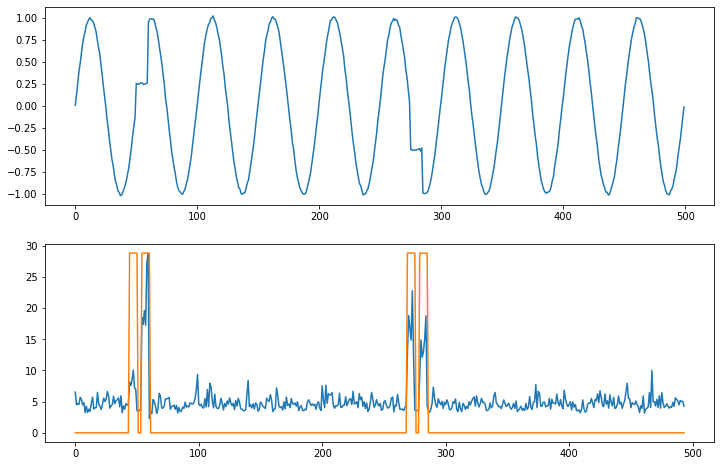

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,8))
ax1.plot(sin_ts)
ax2.plot(mean_codisps)
ax2.plot(anomalous_shingles*mean_codisps.max())

In [ ]:
# Finding the score threshold, above which we classify windows as anomalous

min_loss = None
score_thresholds = []

loss_log = {}

for t in tqdm(np.linspace(mean_codisps.min(), mean_codisps.max(), num=10000, endpoint=True)):
    loss = anomaly_loss(mean_codisps > t, anomalous_shingles)

    if min_loss is None or min_loss > loss:
        min_loss = loss
        score_thresholds = []

    if min_loss == loss:
        score_thresholds.append(t)

    loss_log[t] = loss

score_threshold = np.sort(score_thresholds)[len(score_thresholds)//2]

print(min_loss)


0


<BarContainer object of 1 artists>

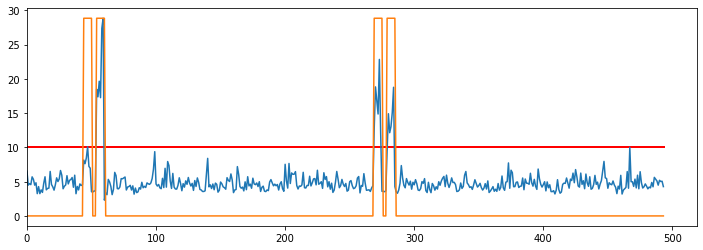

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(mean_codisps)
plt.plot(anomalous_shingles*mean_codisps.max())
plt.barh(score_threshold, len(mean_codisps), height=0.2, color='r')

In [ ]:
fp, fn = misclassifications(mean_codisps > score_threshold, anomalous_shingles)
print("False positives: ", fp)
print("False negatives: ", fn)

False positives:  0
False negatives:  0


Although it seems to work flawlessly, we can see that the difference between the lowest anomaly and highest non-anomally score if really small, so it's very likely to make mistakes ocasionally.

#### Long time series with stream data

In [ ]:
ts_len = 1000
threshold = 700
shingle_len = 7

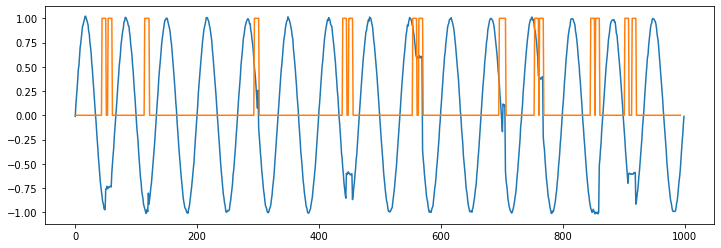

In [ ]:
# Generate an artificial anomalous time series

anomalies = (
    (50, 60, -0.75),
    (120, 121, -0.8),
    (300, 301, 0.25),
    (445, 455, -0.6),
    (560, 570, 0.6),
    (702, 706, 0.1),
    (760, 768, 0.4),
    (852, 860, -1),
    (908, 920, -0.6)
    )

sin_ts, _, sin_shingles, anomalous_shingles = generate_anomalous_sin(ts_len, anomalies,
                                                                     shingle_len=shingle_len,
                                                                     end=30*np.pi,
                                                                     noise=0.01,
                                                                     seed=123)
plt.figure(figsize=(12,4))
plt.plot(sin_ts)
plt.plot(anomalous_shingles)

In [ ]:
initial_data = sin_shingles[:threshold]
stream_data = sin_shingles[threshold:]

In [ ]:
forest = RobustRandomCutForest(initial_data, 60, leaf_threshold=np.exp(-20), seed=42)

In [ ]:
mean_codisps = np.zeros(ts_len - shingle_len + 1)
mean_codisps[:threshold] = forest.get_mean_codisps()

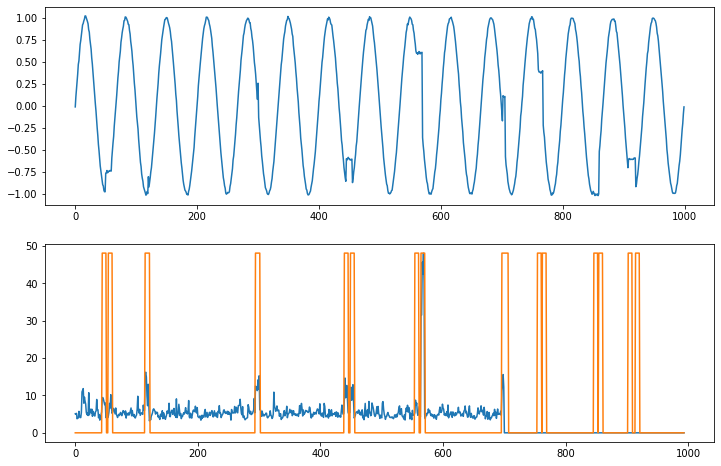

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,8))
ax1.plot(sin_ts)
ax2.plot(mean_codisps)
ax2.plot(anomalous_shingles*mean_codisps.max())

In [ ]:
min_loss = np.infty
score_thresholds = []

loss_log = {}

for t in tqdm(np.linspace(mean_codisps.min(), mean_codisps.max(), num=10000, endpoint=True)):
    loss = anomaly_loss(mean_codisps[:threshold] > t, anomalous_shingles[:threshold])

    if min_loss > loss:
        min_loss = loss
        score_thresholds = []

    if min_loss == loss:
        score_thresholds.append(t)

    loss_log[t] = loss

score_threshold = np.sort(score_thresholds)[len(score_thresholds)//2]

print(min_loss)


9


In [ ]:
anomaly_loss(mean_codisps[:threshold] > score_threshold, anomalous_shingles[:threshold])

9

In [ ]:
fp, fn = misclassifications(mean_codisps[:threshold] > score_threshold, anomalous_shingles[:threshold])
print("False positives: ", fp)
print("False negatives: ", fn)

False positives:  0
False negatives:  3


Text(0, 0.5, 'Loss')

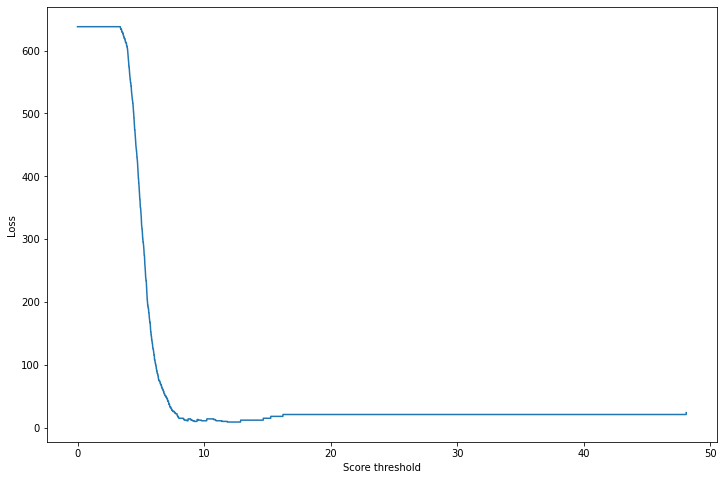

In [ ]:
# Loss depending on chosen codisp score threshold
# Multiple local minima can be seen
plt.figure(figsize=(12,8))
plt.plot(list(loss_log.keys()), list(loss_log.values()))
plt.xlabel("Score threshold")
plt.ylabel("Loss")

<BarContainer object of 1 artists>

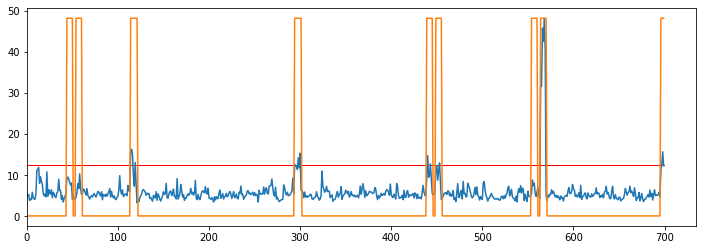

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(mean_codisps[:threshold])
plt.plot(anomalous_shingles[:threshold]*mean_codisps.max())
plt.barh(score_threshold, threshold, height=0.2, color='r')

In [ ]:
points = [shingle[1] for shingle in stream_data.iterrows()]
for point_idx in range(len(points)):
    point = points[point_idx]
    forest.insert_point(point)
    mean_codisps[threshold + point_idx] = forest.get_mean_codisps(points=[point])[0]

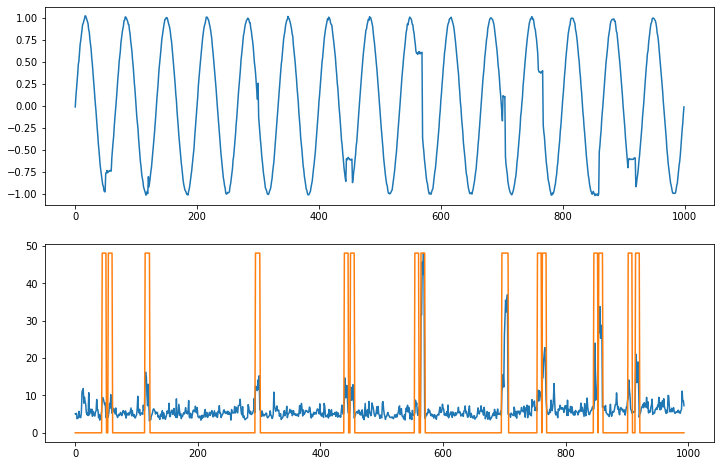

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,8))
ax1.plot(sin_ts)
ax2.plot(mean_codisps)
ax2.plot(anomalous_shingles*mean_codisps.max())

<BarContainer object of 1 artists>

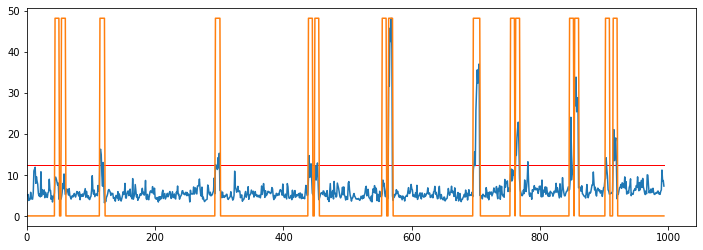

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(mean_codisps)
plt.plot(anomalous_shingles*mean_codisps.max())
plt.barh(score_threshold, len(mean_codisps), height=0.2, color='r')

In [ ]:
fp, fn = misclassifications(mean_codisps > score_threshold, anomalous_shingles)
print("False positives: ", fp)
print("False negatives: ", fn)

False positives:  2
False negatives:  4


## Real data

Unfortunately I didn't manage to label anomalies in those datasets,
so I didn't calculate accuracy for these datasets.

### Reading the data

In [ ]:
urls = [
        'http://bitpeak.pl/datasets/ASC_AntenaEvent.csv',
        'http://bitpeak.pl/datasets/BCL_TaskCreation.csv',
        'http://bitpeak.pl/datasets/DTTB_IncomeEvents.csv',
]

dfs = [pd.read_csv(url,
                   sep=';',
                   index_col=['dataStream', 'probingTimestamp'],
                   parse_dates=['probingTimestamp']) for url in urls]

for df in dfs:
    df.columns = ['rows']

df = pd.concat(dfs)

### Checking how often changes occur
(Initially we have a measurement for each minute)

In [ ]:
df['diff'] = df['rows'].groupby('dataStream').diff()
for name, ts in df.groupby('dataStream'):
    print(name)
    dt = ts.index.droplevel(0) # datetime
    constant_days = (ts['diff'].groupby(by=[dt.date]).agg('mean') == 0).sum()
    print(f'Number of days when the value doesn\'t change: {constant_days}')
    constant_hours = (ts['diff'].groupby(by=[dt.date, dt.hour]).agg('mean') == 0).sum()
    print(f'Number of hours when the value doesn\'t change: {constant_hours}')
    print()

ASC_AntenaEvent
Number of days when the value doesn't change: 1
Number of hours when the value doesn't change: 726

BCL_TaskCreation
Number of days when the value doesn't change: 0
Number of hours when the value doesn't change: 41

DTTB_IncomeEvents
Number of days when the value doesn't change: 0
Number of hours when the value doesn't change: 559



In the first and third time series, we should aggregate the data daily.  
In the second, we can do so hourly.

### Preprocessing

In [ ]:
# Aggregation by daily/ hourly mean
dfs = []
for (ts_name, ts), time_period in zip(df.groupby('dataStream'), ['D', 'H', 'D']):
    temp_ts = pd.DataFrame(ts['rows'].droplevel(0).resample(time_period).mean())
    temp_ts['dataStream'] = ts_name
    temp_ts = temp_ts.reset_index()
    temp_ts = temp_ts.set_index(['dataStream', 'probingTimestamp'])
    dfs.append(temp_ts)
df_reduced = pd.concat(dfs)

In [ ]:
# First order differentiating
df_reduced['diff'] = df_reduced['rows'].groupby('dataStream').diff().values

### Tests

#### ASC_AntenaEvent

In [ ]:
ts = df_reduced.loc['ASC_AntenaEvent']

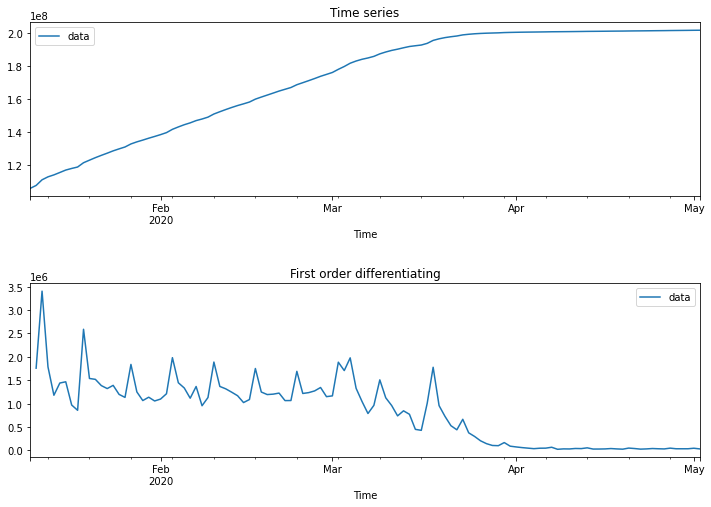

In [ ]:
plot_stats(ts)

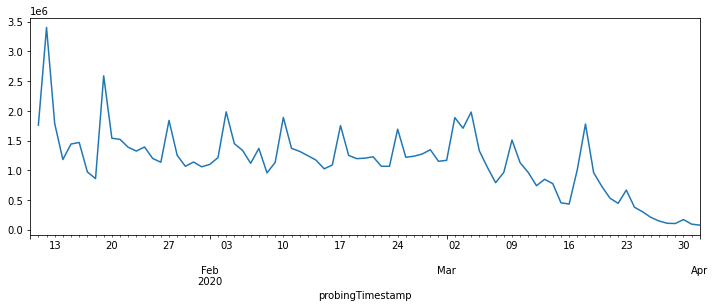

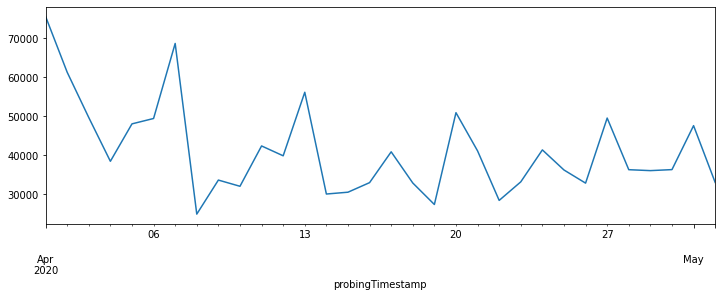

In [ ]:
# Change in the trend that happened around 1st of April
plt.figure(figsize=(12,4))
ts[:'2020-04-01']['diff'].plot()
plt.figure(figsize=(12,4))
ts['2020-04-01':]['diff'].plot()

In [ ]:
shingles = shingle(ts['diff'].dropna().values, 7)

In [ ]:
forest = RobustRandomCutForest(shingles, 40, leaf_threshold=np.exp(-20), seed=42)

In [ ]:
mean_codisps = forest.get_mean_codisps()

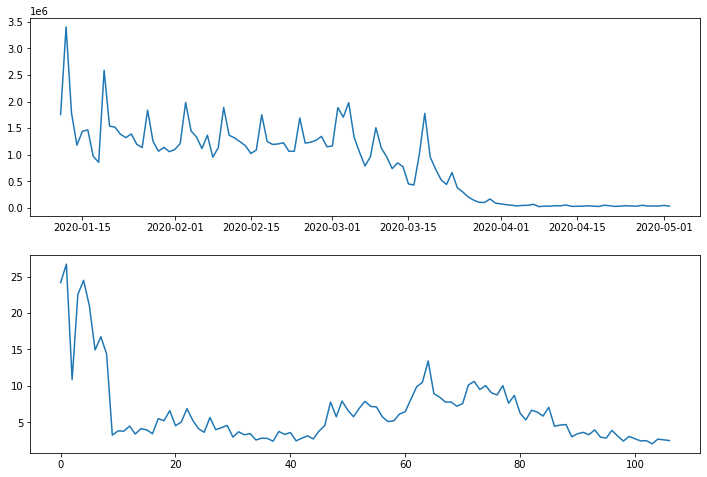

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,8))
ax1.plot(ts['diff'])
ax2.plot(mean_codisps)

We can see that the algorithm identifies the first two peaks as much higher than the rest.  
It also yields higher scores for the period of 15.03 - 01.04, which corresponds to the biggest change in the data.

#### BCL_TaskCreation

In [ ]:
ts = df_reduced.loc['BCL_TaskCreation']

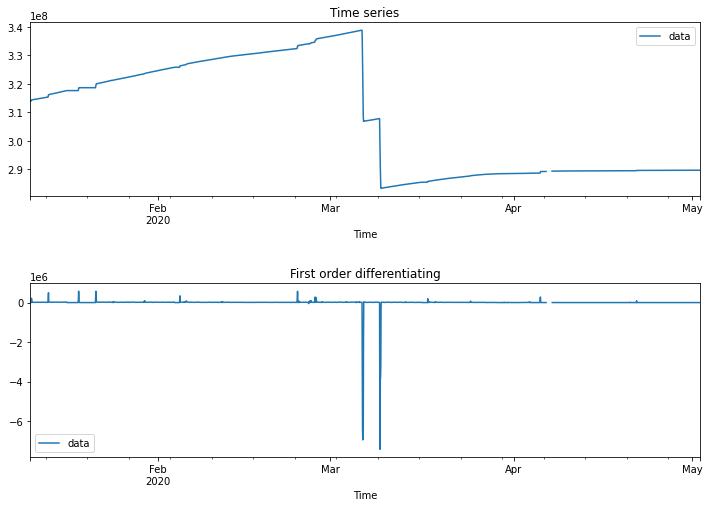

In [ ]:
plot_stats(ts)

In [ ]:
shingles = shingle(ts['diff'].dropna().values, 7)

In [ ]:
forest = RobustRandomCutForest(shingles, 40, leaf_threshold=np.exp(-20), seed=42)

In [ ]:
mean_codisps = forest.get_mean_codisps()

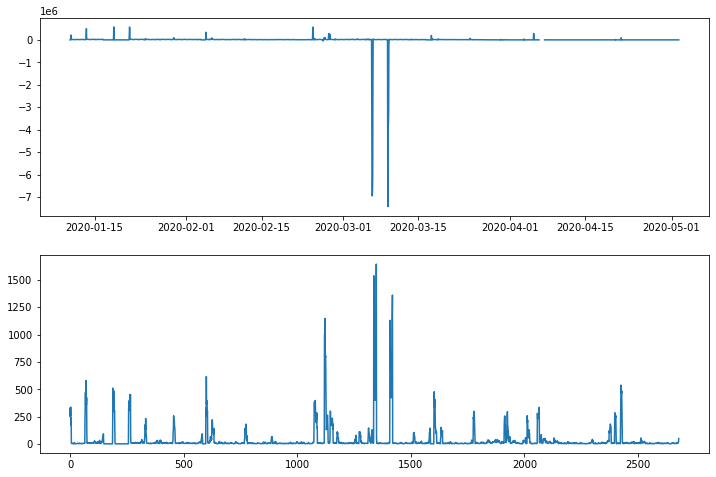

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,8))
ax1.plot(ts['diff'])
ax2.plot(mean_codisps)

The algorithm seems to identify most of the anomalies here, with the largest ones yielding highest scores.

#### DTTB_IncomeEvents

In [ ]:
ts = df_reduced.loc['BCL_TaskCreation']

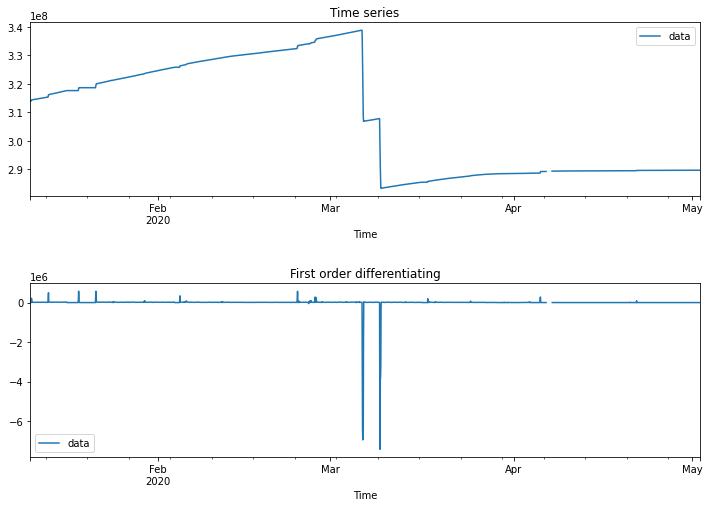

In [ ]:
plot_stats(ts)

In [ ]:
shingles = shingle(ts['diff'].dropna().values, 7)

In [ ]:
forest = RobustRandomCutForest(shingles, 40, leaf_threshold=np.exp(-20), seed=42)

In [ ]:
mean_codisps = forest.get_mean_codisps()

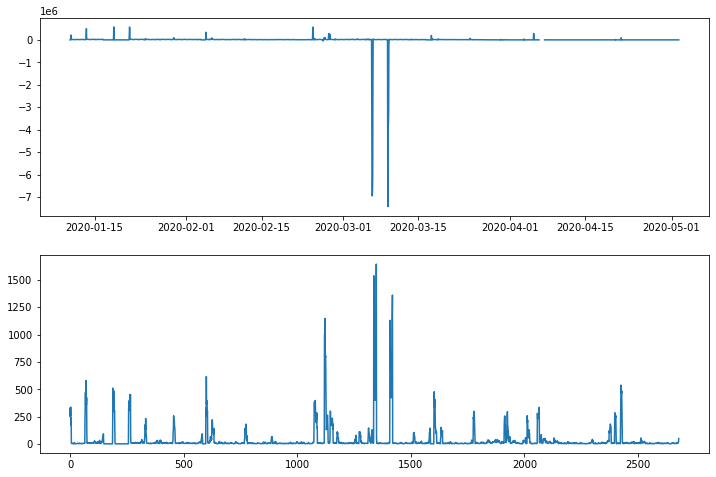

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,8))
ax1.plot(ts['diff'])
ax2.plot(mean_codisps)

## MNIST

### Loading the data

In [ ]:
# We can drop the labels and the test set
(mnist_data, _), _ = mnist.load_data()
# Change to dataframe for use with RRCF
mnist_df = pd.DataFrame(mnist_data.reshape(-1, 28*28))

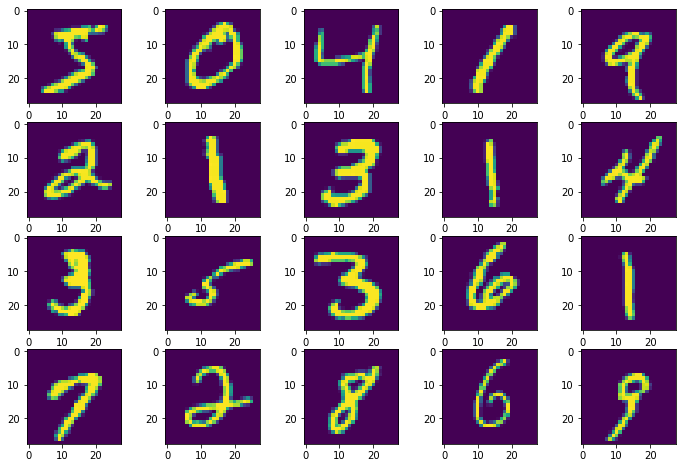

In [ ]:
nrows, ncols = 4, 5

fig, axes = plt.subplots(nrows, ncols, figsize=(12,8))

for row in range(nrows):
    for col in range(ncols):
        axes[row][col].imshow(mnist_data[row*ncols + col])


In [ ]:
# We can drop the labels and the test set
(fashion_data, _), _ = fashion_mnist.load_data()
# Change to dataframe for use with RRCF
fashion_df = pd.DataFrame(fashion_data.reshape(-1, 28*28))

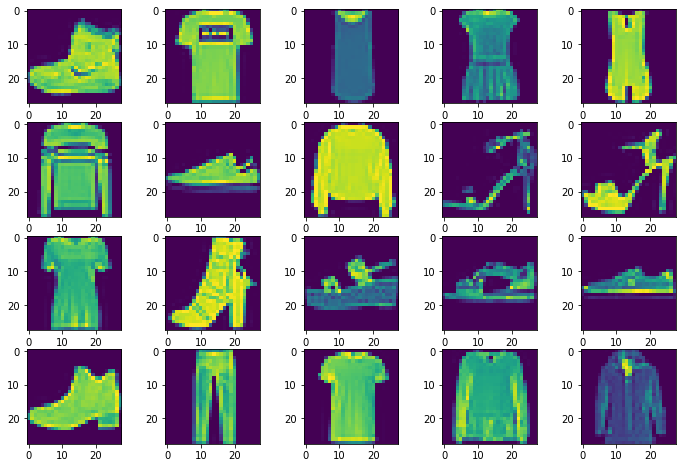

In [ ]:
nrows, ncols = 4, 5

fig, axes = plt.subplots(nrows, ncols, figsize=(12,8))

for row in range(nrows):
    for col in range(ncols):
        axes[row][col].imshow(fashion_data[row*ncols + col])

### Regular MNIST

#### RRCF

In [ ]:
# Reducing the dataset for faster computation
df = mnist_df.iloc[:3000]

In [ ]:
RRCF = RobustRandomCutForest(df, num_trees=10, seed=42)

In [ ]:
codisps = RRCF.get_mean_codisps()

In [ ]:
anomalies_indices = np.argsort(codisps)[::-1]

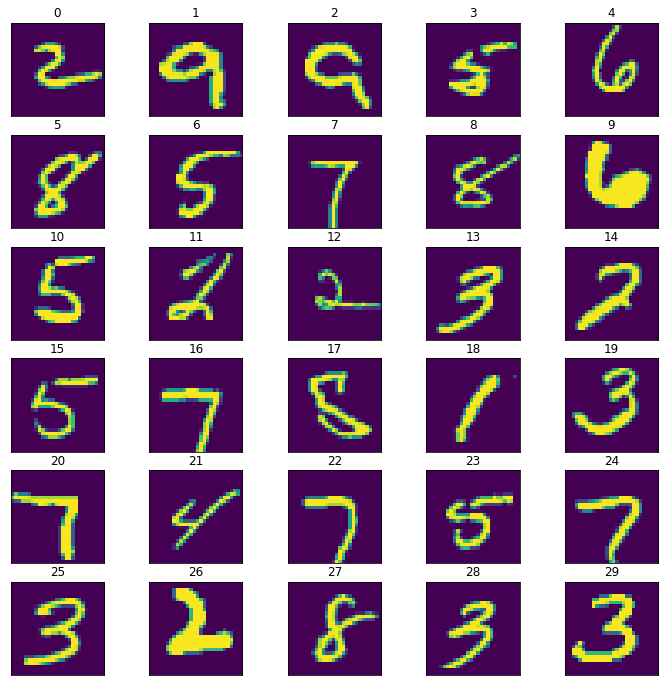

In [ ]:
# Plotting samples classified as anomalies

nrows, ncols = 6, 5

fig, axes = plt.subplots(nrows, ncols, figsize=(12,12))

for row in range(nrows):
    for col in range(ncols):
        axes[row][col].imshow(mnist_data[anomalies_indices[row*ncols + col]])
        axes[row][col].set_title(row*ncols + col)
        axes[row][col].get_xaxis().set_visible(False)
        axes[row][col].get_yaxis().set_visible(False)

We can see that multiple anomalies are amongst the top scored samples (notably samples 2, 3, 8, 9, 11 and 17).  
Unfortunately, there are also numerous false positives. It suggests that this approach may not be well-suited to the task, as the algoritm checks the individual pixels, which leads to boldened (e.g. 26) or elongated/shifted (e.g. 7, 15) samples yielding high scores.

### With fashion MNIST

In order to create a dataset where anomalies are labeled, I add 10 samples of fashion MNIST to regular one.

In [ ]:
data = np.concatenate((mnist_data[:3000], fashion_data[:10]))

In [ ]:
df = pd.DataFrame(data.reshape(-1, 28*28))

#### RRCF

In [ ]:
RRCF = RobustRandomCutForest(df, num_trees=10, seed=42)

In [ ]:
# Ranks of fashion MNIST samples -
# the lower the rank, the more confident alorithm is that a sample is an anomaly

codisps = RRCF.get_mean_codisps()
anomalies_indices = np.argsort(codisps)[::-1]

np.where(anomalies_indices >= 3000)

(array([ 0,  3,  4,  6,  8, 11, 12, 14, 29, 56]),)

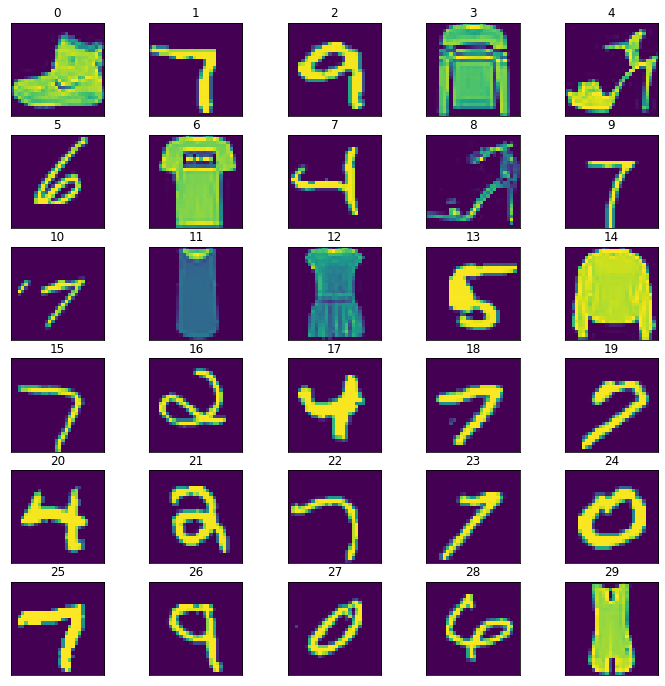

In [ ]:
# Plotting samples classified as anomalies

nrows, ncols = 6, 5

fig, axes = plt.subplots(nrows, ncols, figsize=(12,12))

for row in range(nrows):
    for col in range(ncols):
        axes[row][col].imshow(data[anomalies_indices[row*ncols + col]])
        axes[row][col].set_title(row*ncols + col)
        axes[row][col].get_xaxis().set_visible(False)
        axes[row][col].get_yaxis().set_visible(False)

The algorithm consistently finds the anomalies in the set, in my experiments all of them were always in top 100, with majority being in top 20.

**Another example, unfortunately without a seed and with different fashion MNIST samples:**

Fashion MNIST indices:  
[ 1,  2,  3,  4,  5,  6,  7, 13, 16, 57]

Samples classified as anomalies:

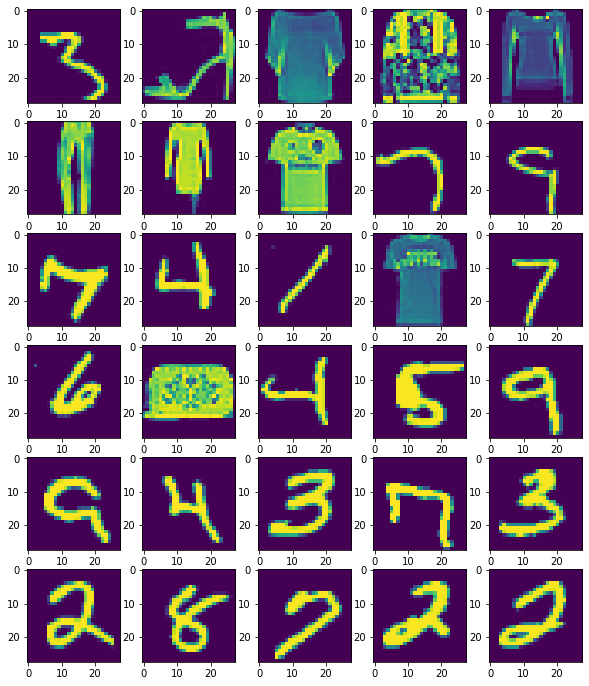

# Conclusions

The algorithm seems to work decently when it comes to finding anomalies.  
Unfortunately, all the accuracy measures I came up with are lacking, so there is no good framework for comparing the results with other algorithm. 
As such, it's hard to objectively measure how good the algorithm is.

Having that in mind, the further perspectives for the project are:

*   Label some real data for testing / Find other, pre-labeled data
*   Implement other algorithms for comparison
*   Improve efficiency of algorithm (mainly by employing multithreading)

